In [63]:
# setup e test librerie
#%pip install numpy
#%pip install pandas
#%pip install matplotlib
#%pip install scikit-learn
#%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Loading Datasets

In [179]:
dailyCalories = pd.read_csv("Fitabase Data 4.12.16-5.12.16/dailyCalories_merged.csv")
dailyIntensities = pd.read_csv("Fitabase Data 4.12.16-5.12.16/dailyIntensities_merged.csv")
dailySteps = pd.read_csv("Fitabase Data 4.12.16-5.12.16/dailySteps_merged.csv")
dailyDistances = pd.read_csv("Fitabase Data 4.12.16-5.12.16/dailyDistances_merged.csv")
dailySleep = pd.read_csv("Fitabase Data 4.12.16-5.12.16/sleepDay_merged.csv")
heartrateSeconds = pd.read_csv("Fitabase Data 4.12.16-5.12.16/heartrate_seconds_merged.csv")
weightLog = pd.read_csv("Fitabase Data 4.12.16-5.12.16/weightLogInfo_merged.csv")

In [193]:
from functools import reduce 

# merge dei dataset
activity_dfs = [dailyCalories, dailyIntensities, dailySteps, dailyDistances]
activity_dfs = [df.assign(Day=pd.to_datetime(df['Day'])) for df in activity_dfs]

dailyActivities = reduce(lambda left,right: pd.merge(left,right,on=['Id', 'Day'], how='outer'), activity_dfs)

# raffinamento dei dati
dailyActivities.set_index(['Id'], inplace=True)
dailyActivities['Day'] = pd.to_datetime(dailyActivities['Day'])
dailyActivities = dailyActivities[dailyActivities['Calories'] >200]
dailyActivities = dailyActivities[dailyActivities['StepTotal'] >100]
dailyActivities.head(5)

,Day,Calories,SedentaryMinutes,LightlyActiveMinutes,FairlyActiveMinutes,VeryActiveMinutes,SedentaryActiveDistance,LightActiveDistance,ModeratelyActiveDistance,VeryActiveDistance,StepTotal,TotalDistance,TrackerDistance,LoggedActivitiesDistance
Id,,,,,,,,,,,,,,
1503960366,2016-04-12,1985,728,328,13,25,0.0,6.06,0.55,1.88,13162,8.50,8.50,0.0
1503960366,2016-04-13,1797,776,217,19,21,0.0,4.71,0.69,1.57,10735,6.97,6.97,0.0
1503960366,2016-04-14,1776,1218,181,11,30,0.0,3.91,0.40,2.44,10460,6.74,6.74,0.0
1503960366,2016-04-15,1745,726,209,34,29,0.0,2.83,1.26,2.14,9762,6.28,6.28,0.0
1503960366,2016-04-16,1863,773,221,10,36,0.0,5.04,0.41,2.71,12669,8.16,8.16,0.0


## Data Visualization

<Axes: xlabel='StepTotal', ylabel='Calories'>

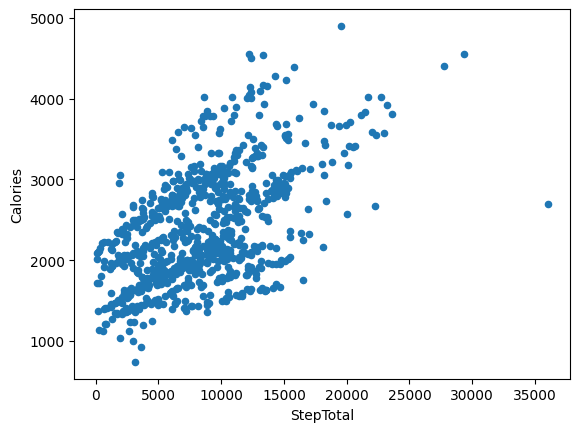

In [195]:
dailyActivities.plot.scatter(x='StepTotal', y='Calories')

<Axes: xlabel='Day', ylabel='TotalMinutesAsleep'>

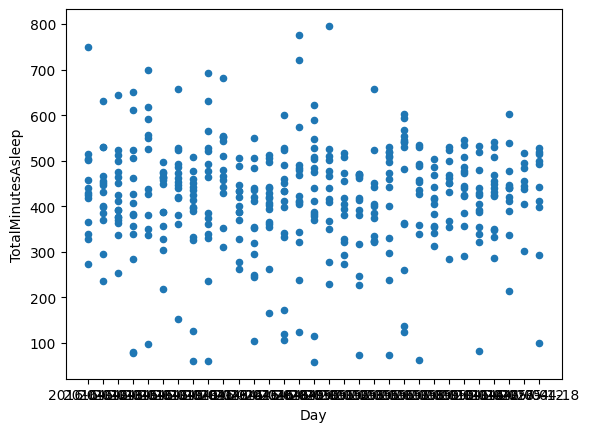

In [196]:
dailySleep.plot.scatter(x='Day', y='TotalMinutesAsleep')

<Axes: xlabel='TotalTimeInBed', ylabel='TotalMinutesAsleep'>

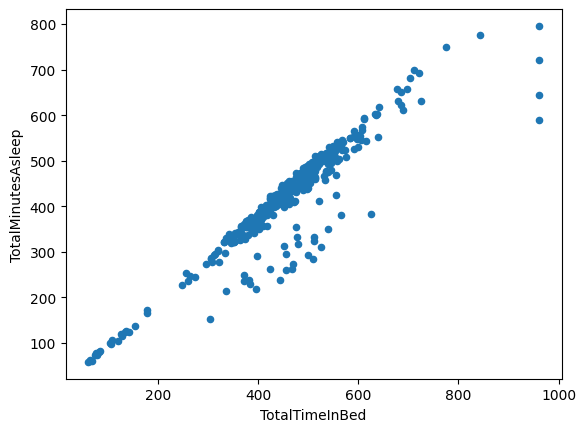

In [197]:
dailySleep.plot.scatter(x='TotalTimeInBed', y='TotalMinutesAsleep')

### Kcal comsumption prediction

In [198]:
# MSE e R^2 sono incluse in scikit-learn
from sklearn.metrics import mean_squared_error, r2_score

# definisco l'errore relativo
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

def print_eval(X, y, model):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    re = relative_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")

In [199]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,KFold

X = dailyActivities.drop(["Day", "Calories", "TrackerDistance", "LoggedActivitiesDistance"], axis=1)
y = dailyActivities["Calories"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

   Mean squared error: 1.4382e+05
       Relative error: 13.58717%
R-squared coefficient: 0.7339


In [200]:
model_b = Pipeline([
    ("poly",   PolynomialFeatures(degree=1, include_bias=False)),
    ("linreg", LinearRegression())
])
model_b.fit(X_train, y_train)
print_eval(X_val, y_val, model_b)

   Mean squared error: 1.4382e+05
       Relative error: 13.58717%
R-squared coefficient: 0.7339


In [201]:
model_c = Pipeline([
    ("poly",   PolynomialFeatures(degree=1, include_bias=False)),
    ("scale",  StandardScaler()),
    ("linreg", LinearRegression())
])
model_c.fit(X_train, y_train)
print_eval(X_val, y_val, model_c)

   Mean squared error: 1.4382e+05
       Relative error: 13.58717%
R-squared coefficient: 0.7339


In [202]:
rrm = Pipeline([
    ("poly", PolynomialFeatures(degree=1, include_bias=False)),
    ("scale", StandardScaler()),
    ("ridge", Ridge(alpha=0.1))
])
rrm.fit(X_train, y_train)
print_eval(X_val, y_val, rrm)

   Mean squared error: 1.444e+05
       Relative error: 13.63381%
R-squared coefficient: 0.73282


In [203]:
def test_regression(degree, alpha):
    rrm = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("scale", StandardScaler()),
        ("ridge", Ridge(alpha=alpha))
    ])
    rrm.fit(X_train, y_train)
    return rrm.score(X_val, y_val)

In [204]:
res_degree = np.arange(1, 10)
res_low_reg = np.array([test_regression(d, 0.01) for d in res_degree])

In [205]:
res_high_reg = np.array([test_regression(d, 10) for d in res_degree])

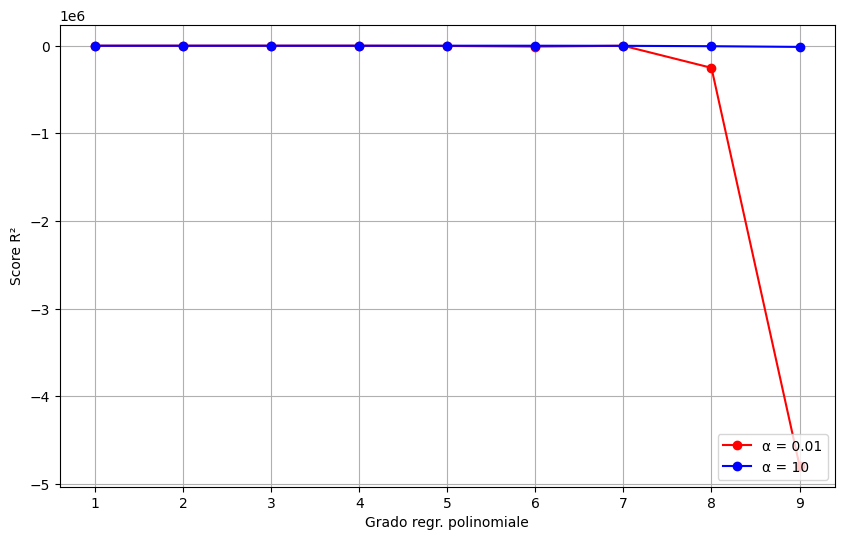

In [206]:
plt.figure(figsize=(10, 6))
plt.plot(res_degree, res_low_reg, "ro-")
plt.plot(res_degree, res_high_reg, "bo-")
plt.grid()
plt.xlabel("Grado regr. polinomiale")
plt.ylabel("Score R²")
# aggiungiamo una legenda al grafico
plt.legend(["α = 0.01", "α = 10"], loc="lower right");

In [207]:
scaled = Pipeline([
    ("scale", StandardScaler()),
    ("lr", LinearRegression())
])
scaled.fit(X_train, y_train)

simple = LinearRegression()
simple.fit(X_train, y_train)

ridge = Pipeline([
    ("scale", StandardScaler()),
    ("ridge", Ridge(alpha=0.1))
])
ridge.fit(X_train, y_train)

pd.DataFrame({
    "linear": simple.coef_,
    "ridge": ridge.named_steps["ridge"].coef_,
    "scaled": scaled.named_steps["lr"].coef_
}, index=X_train.columns)

,linear,ridge,scaled
SedentaryMinutes,0.232371,63.608542,63.252776
LightlyActiveMinutes,-0.350245,-36.952925,-33.347780
FairlyActiveMinutes,10.728450,212.776911,211.484532
VeryActiveMinutes,17.745851,577.539646,581.315458
SedentaryActiveDistance,-3852.485185,-28.638618,-29.113572
LightActiveDistance,27.062878,60.306145,50.057039
ModeratelyActiveDistance,-298.986899,-254.274827,-255.466612
VeryActiveDistance,-278.322418,-703.735067,-719.539077
StepTotal,-0.391306,-1746.941778,-1773.603144
TotalDistance,667.569916,2326.233426,2368.605167


In [208]:
lasso = Pipeline([
    ("scale", StandardScaler()),
    ("regr", Lasso(alpha=1))
])
lasso.fit(X_train, y_train)
print_eval(X_val, y_val, lasso)
pd.Series(lasso.named_steps["regr"].coef_, X_train.columns)

   Mean squared error: 1.4578e+05
       Relative error: 13.75960%
R-squared coefficient: 0.73027


SedentaryMinutes              63.143516
LightlyActiveMinutes         -37.785655
FairlyActiveMinutes          199.458579
VeryActiveMinutes            569.460927
SedentaryActiveDistance      -27.277889
LightActiveDistance           75.483079
ModeratelyActiveDistance    -234.815316
VeryActiveDistance          -665.992522
StepTotal                  -1690.037732
TotalDistance               2233.364176
dtype: float64

In [209]:
lasso2 = Pipeline([
    ("scale", StandardScaler()),
    ("regr", Lasso(alpha=0.2))
])
lasso2.fit(X_train, y_train)
print_eval(X_val, y_val, lasso2)
pd.Series(lasso2.named_steps["regr"].coef_, X_train.columns)

   Mean squared error: 1.4414e+05
       Relative error: 13.61744%
R-squared coefficient: 0.73331


SedentaryMinutes              63.231332
LightlyActiveMinutes         -34.251327
FairlyActiveMinutes          209.091448
VeryActiveMinutes            578.927282
SedentaryActiveDistance      -28.744059
LightActiveDistance           55.158177
ModeratelyActiveDistance    -251.351501
VeryActiveDistance          -708.802547
StepTotal                  -1756.771002
TotalDistance               2341.427781
dtype: float64

In [210]:
elasticNet = Pipeline([
    ("scale",  StandardScaler()),
    ("regr", ElasticNet(alpha=0.2, l1_ratio=0.1))
])
elasticNet.fit(X_train, y_train)
print_eval(X_val, y_val, elasticNet)

   Mean squared error: 2.9192e+05
       Relative error: 19.37794%
R-squared coefficient: 0.45988


In [211]:
def elastic_net_with_alphas(alpha_l2, alpha_l1):
    alpha = alpha_l1 + alpha_l2
    l1_ratio = alpha_l1 / alpha
    return ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

In [212]:
elasticNetAlphas = Pipeline([
    ("scale", StandardScaler()),
    ("regr", elastic_net_with_alphas(1, 0.1))
])
elasticNetAlphas.fit(X_train, y_train)
print_eval(X_val, y_val, elasticNetAlphas)

   Mean squared error: 3.412e+05
       Relative error: 21.22485%
R-squared coefficient: 0.36869


In [213]:
def multivariate_scaled_elasticnet(degree):
    return Pipeline([
        ("poly", PolynomialFeatures(degree, include_bias=False)),
        ("scale", StandardScaler()),
        ("regr", ElasticNet(alpha=0.5, l1_ratio=0.2))
    ])

In [214]:
mven = multivariate_scaled_elasticnet(2)
mven.fit(X_train, y_train)
print_eval(X_val, y_val, mven)

   Mean squared error: 2.5852e+05
       Relative error: 18.13980%
R-squared coefficient: 0.52168


In [215]:
mven = multivariate_scaled_elasticnet(4)
mven.fit(X_train, y_train)
print_eval(X_val, y_val, mven)

   Mean squared error: 6.8059e+05
       Relative error: 18.18111%
R-squared coefficient: -0.25926


C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.052e+07, tolerance: 3.128e+04
  model = cd_fast.enet_coordinate_descent(


In [216]:
mven = multivariate_scaled_elasticnet(8)
mven.fit(X_train, y_train)
print_eval(X_val, y_val, mven)

   Mean squared error: 9.1587e+07
       Relative error: 43.54527%
R-squared coefficient: -168.46


C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.756e+07, tolerance: 3.128e+04
  model = cd_fast.enet_coordinate_descent(


In [217]:
from sklearn.kernel_ridge import KernelRidge
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="poly", degree=5))
])
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

CPU times: total: 0 ns
Wall time: 43.6 ms
   Mean squared error: 6.6245e+06
       Relative error: 22.74027%
R-squared coefficient: -11.257


In [218]:
rbf_kernel = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=20, kernel="rbf", gamma=0.01))
])
%time model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

CPU times: total: 15.6 ms
Wall time: 42.7 ms
   Mean squared error: 6.6245e+06
       Relative error: 22.74027%
R-squared coefficient: -11.257


In [219]:
from sklearn.model_selection import cross_validate
cv_result = cross_validate(rbf_kernel, X, y, cv=KFold(5, shuffle=True, random_state=42), return_train_score=True)

In [220]:
pd.DataFrame(cv_result).describe()

,fit_time,score_time,test_score,train_score
count,5.000000,5.000000,5.000000,5.000000
mean,0.032505,0.004168,0.206541,0.225221
std,0.000700,0.000618,0.112581,0.014106
min,0.031679,0.003330,0.038986,0.205862
25%,0.032178,0.004000,0.203262,0.215060
50%,0.032451,0.004049,0.206335,0.230786
75%,0.032635,0.004452,0.228877,0.237078
max,0.033579,0.005006,0.355246,0.237321


# Sleep Analysis


In [221]:
dailySleep["SleepClassification"] = "Buono"  # Imposta il valore predefinito a "Buono"
# Applica la regola per classificare il sonno come "cattivo" se TotalMinutesAsleep è inferiore al 50% di TotalTimeInBed
dailySleep.loc[dailySleep["TotalMinutesAsleep"] <  0.8* dailySleep["TotalTimeInBed"], "SleepClassification"] = "Cattivo"

In [222]:
from sklearn.model_selection import train_test_split
# Seleziona le colonne di input e l'etichetta di classe
#X = daily_data[["TotalSleepRecords", "TotalMinutesAsleep", "TotalTimeInBed"]]
X = dailySleep[["TotalMinutesAsleep", "TotalTimeInBed"]]
y = dailySleep['SleepClassification']
# Dividi il dataset in training set e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)


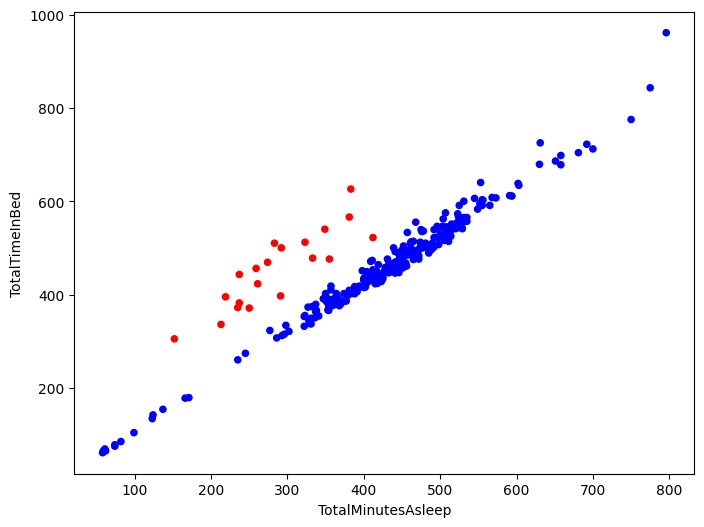

In [223]:
diagnosis_color_map = {"Buono": "blue", "Cattivo": "red"}
X_train.plot.scatter("TotalMinutesAsleep", "TotalTimeInBed", c=y_train.map(diagnosis_color_map), figsize=(8, 6));

In [224]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X2dn_train = scaler.fit_transform(X_train)
X2dn_val = scaler.transform(X_test)

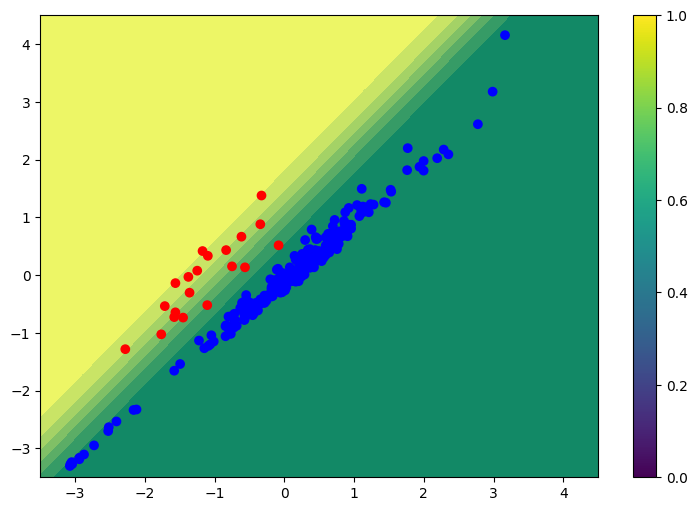

In [225]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="saga", random_state=42)
model.fit(X2dn_train, y_train)
mx1, mx2 = np.meshgrid(np.linspace(-3.5, 4.5, 100), np.linspace(-3.5, 4.5, 100))
my = model.predict_proba(np.c_[mx1.ravel(), mx2.ravel()])[:, 1].reshape(mx1.shape)
plt.figure(figsize=(9, 6))
plt.contourf(mx1, mx2, my, cmap="summer")
plt.scatter(*X2dn_train.T, c=y_train.map(diagnosis_color_map))
plt.colorbar();

In [226]:
model.score(X2dn_val, y_test)

0.9782608695652174